**A**lbeit research continuously yields successful applications of reinforcement learning (RL), used algorithms usually do not ensure safety during training or deployment. However, real world system often rely on safety guarantees. Compared to safe RL, provably safe RL aims not only at high-probability safety guarantees, but the provable absence of unsafe behavior during training and deployment.<br>

In this project, we work with action masking, post-posed shielding and discrete-time control barrier functions to guarantee provably safe RL. These safety approaches have been implemented as [Gym](https://gym.openai.com) wrappers.

Disclaimer: Make sure to run the cells in order.  If you use ``rollout``, you might have to force-quit the rendered window (or leave it open until the end).

**Imports**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import gym
import numpy as np
from numpy import pi
from main import main, rollout
from util import animate
from IPython.display import display, HTML
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from IPython.display import Image

The inverted pendulum task modeled with a mathematical pendulum is used in the following example.

In [2]:
from gym.envs.registration import register
register(
    id='MathPendulum-v0',
    max_episode_steps=100,
    entry_point='sb3_contrib.common.envs.pendulum.math_pendulum_env:MathPendulumEnv'
)

The safety constraints are defined via a ``safeRegion`` instance. The ``safeRegion`` class supports convex polytopes that can be passed in vertex- or half-space-representation. The class overwrites ``__contains__`` to return whether a state is in- or outside of the polytope.

The safe region for the pendulum environment is a (precomputed) region of attraction. It is bounded via LQR constraints. The safe region can be passed to the environment a posteriori. Once the pendulum violates the safety restriction, its color turns orange.

In [3]:
from pendulum_roa import PendulumRegionOfAttraction #Subclass of safeRegion

theta_roa = 3.092505268377452
vertices = np.array([
    [-theta_roa, 12.762720155208534],  
    [theta_roa, -5.890486225480862],  
    [theta_roa, -12.762720155208534], 
    [-theta_roa, 5.890486225480862] 
])

# Pass as vertex or half-space representation.
safe_region = PendulumRegionOfAttraction(vertices=vertices)

The utility method rollout can be used to sample from the environment. Without further configuration, random and continuous actions will be taken. One should see that we quickly breach the safe region (pendulum turns orange).

In [4]:
# Initialise environment
env = gym.make('MathPendulum-v0', init="random", safe_region=safe_region)
# Wrap with Monitor (suppress warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

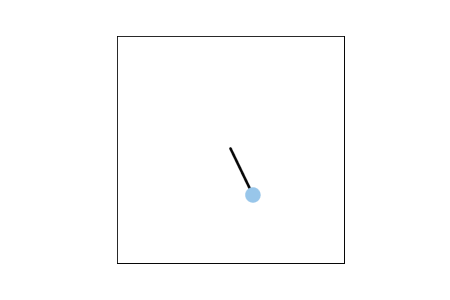

In [5]:
#rollout(env, render=True, rgb_array=False, sleep=.05)

# imagemagick required
frames = rollout(env, render=True, rgb_array=True, sleep=0)
anim = animate(frames, dpi=75)
anim.save('gifs/env.gif', writer='imagemagick', fps=20)
with open('gifs/env.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

**Safety Wrappers**

All safety wrappers require application-specific functionality. It can be specified by means of unbounded functions. If they are already implemented in the underlying environment, one can specify the function via string.

Disclaimer: Even though the safety wrappers are applied, safety violations might occasionally happen in the exemplified benchmark. This is not further elaborated in this notebook. We remark that this is not an issue of the wrappers, but rather due to the specific setup.

[Required/Optional] **dynamics_fn**<br>
The function ``dynamics_fn`` is parameterized by the environment and the agent’s action. It returns the next state of the variables that need to be rendered safe. As an example, if the safe region is a convex polytope that defines safe environment states, then `` dynamics_fn``  returns the next state of the environment.
<br>



In [6]:
def dynamics_fn(env, action):
    # Reuse the environment's state and dynamics
    theta, thdot = env.state
    return env.dynamics(theta, thdot, action)

[Required/None] **safe_action_fn**<br>
Agents that utilize action masking or post-posed shielding must be able to resort to a verified fail-safe controller. The function ``safe_action_fn`` is parameterized by the environment, the safe region and the agent’s action. It returns a verified fail-safe action.
<br>

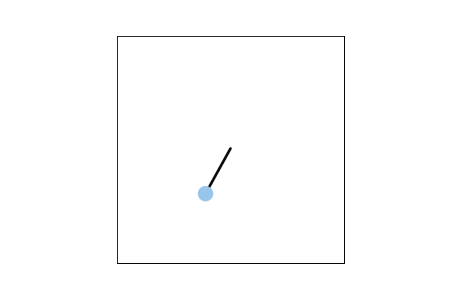

In [7]:
def safe_action_fn(env, safe_region, action):
    # LQR gain matrix
    gain_matrix = [19.670836678497427, 6.351509533724627]
    if isinstance(env, DummyVecEnv):
        state = env.get_attr("state")[0]
    else: 
        state = env.state
    return -np.dot(gain_matrix, state)

# Rollout
#rollout(env, render=True, rgb_array=False, safe_action_fn=safe_action_fn, sleep=0.1)

# Rollout and save as gif
frames = rollout(env, render=True, safe_action_fn=safe_action_fn, rgb_array=True, sleep=0)
anim = animate(frames, dpi=75)
anim.save('gifs/lqr.gif', writer='imagemagick', fps=20)
with open('gifs/lqr.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

[Optional/None] **punishment_fn**<br> 
The optional function ``punishment_fn`` returns a reward that is added to the overall reward, e.g., a negative value, which incentives the policy to not rely on safety corrections. It is parameterized by the environment, the safe region and the policies’s action. Moreover, it is parameterized by

- the current and the next action mask in the case of action masking. If the fail-safe action is used, it replaces the agent’s action.
- the fail-safe action in the case of the post-posed shielding.
- the control compensation in the case of the CBF wrapper.<br>

[Optional] **transform_action_space_fn**<br>
The environment might accept continuous actions, e.g., for fail-safe control. In contrast, the agent might predict discrete actions, e.g., necessary for action masking. Consequently, the action space has to be transformed in between the policy’s output and the environment’s step function. As a result, all wrappers can be supplied with an alternative Gym action space ``alter_action_space``: Optional[gym.Space] and a transformation function ``transform_action_space_fn``.
<br>

In [8]:
alter_action_space = gym.spaces.Discrete(21)
transform_action_space_fn = lambda a: 3 * (a - 10)

**Action Mask Wrapper**

For every time step, the wrapper generates binary a mask, which is called the action mask. It encodes safety information about all actions in the action space by masking out unsafe actions. The RL algorithm incorporates the action mask into its decision process. As a result, the action mask reduces the action space to the subspace of safe actions. To guarantee safe behavior, a safe-fail controller is needed. The agent falls back to a temporary auxiliary action whenever
every action is masked out. If this is the case, the action mask component substitutes
the auxiliary action by a verified fail-safe action. If safe actions can be taken, then the auxiliary action is always masked out.

[Required] ``environment``, ``safeRegion``, ``dynamics_fn``, ``safe_action_fn``<br>
[Optional] ``punishment_fn``, ``alterActionSpace``, ``transform_action_space_fn``

Alters info s.t. 

```python
info["mask"] = {"action_rl": 0 iff the auxiliary action was used otherwise the policies´s RL action
                "last_mask": The action mask used during the last step
                "next_mask": The action mask that will be used during the following step
                "safe_action": None or the fail-safe action
                "reward_rl": The environment´s reward without punishment
                "punishment": None or the reward punishment
```

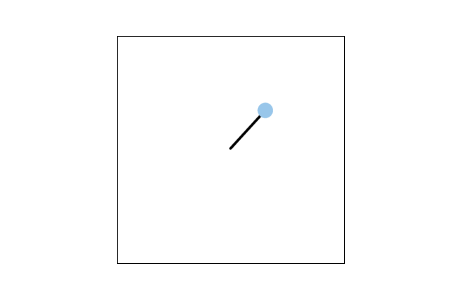

In [9]:
from sb3_contrib import SafetyMask

def punishment_fn(env, safe_region, action_rl, mask, next_mask):
    if mask[-1] == 1:
        return min(0, np.sum(next_mask[:-1]) - np.sum(mask[:-1]), -abs(action_rl))
    else:
        return min(0, np.sum(next_mask[:-1]) - np.sum(mask[:-1]))
    
# Initialise environment
env = gym.make('MathPendulum-v0', init="random", safe_region=safe_region)

env = SafetyMask(
                env=env,
                safe_region=safe_region,
                dynamics_fn=dynamics_fn,
                safe_action_fn=safe_action_fn,
                punishment_fn=punishment_fn,
                transform_action_space_fn=transform_action_space_fn,
                alter_action_space=alter_action_space)

# Wrap with Monitor (suppress warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

# Rollout
#rollout(env, render=True, rgb_array=False, sleep=0.25)

# Rollout and save as gif
frames = rollout(env, render=True, rgb_array=True, sleep=0)
anim = animate(frames, dpi=75)
anim.save('gifs/mask.gif', writer='imagemagick', fps=20)
with open('gifs/mask.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

**Post-posed Shielding**

For every time step, the agent
takes an action at as it would without shielding. The post-posed shield wrapper is
implemented as an intermediary in between the agent and the environment. It receives the action and decides whether it is safe or not. In case the action is safe, it
can be forwarded to the environment. In case it is not, at is substituted by a safe action, which is provided by a verified fail-safe controller. 

[Required] ``environment``, ``safeRegion``, ``dynamics_fn``, ``safe_action_fn``<br>
[Optional] ``punishment_fn``, ``alterActionSpace``, ``transform_action_space_fn``

Alters info s.t. 

```python
info["shield"] = {"action_rl": The policies´s RL action
                  "safe_action": None or the fail-safe action
                  "reward_rl": The environment´s reward without punishment
                  "punishment": None or the reward punishment
```

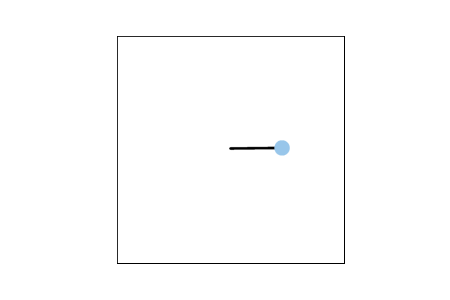

In [10]:
from sb3_contrib import SafetyShield

def punishment_fn(env, safe_region, action_rl, safe_action):
    return -abs(action_rl - safe_action)

# Initialise environment
env = gym.make('MathPendulum-v0', init="random", safe_region=safe_region)

env = SafetyShield(
            env=env,
            safe_region=safe_region,
            dynamics_fn=dynamics_fn,
            safe_action_fn=safe_action_fn,
            punishment_fn=punishment_fn,
            transform_action_space_fn=transform_action_space_fn,
            alter_action_space=alter_action_space)

# Wrap with Monitor (suppress warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

# Rollout
#rollout(env, render=True, rgb_array=False, sleep=0.1)

# Rollout and save as gif
frames = rollout(env, render=True, rgb_array=True, sleep=0)
anim = animate(frames, dpi=75)
anim.save('gifs/shield.gif', writer='imagemagick', fps=20)
with open('gifs/shield.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

**Discrete-time control barrier functions**

CBFs yield forward set invariance for a given set. In other words, applied to safe RL, they guarantee that the system state never leaves aforementioned set. Due to this property, this set is referred to as the safe set. Thus, one can directly set the safe region as the safe set. For every time
step, the agent takes an action at as it would without CBFs. The CBF wrapper is
implemented as an intermediary in between the agent and the environment. It receives
the action and solves a QP to satisfy the CBF constraints. The resulting CBF compensation is added to the original action. This sum is proven to be safe and is thus forwarded to the environment.

The CBF wrapper is a special case with regards to the dynamics. To construct the CBF it separates the dynamics into the unactuated- and actuated dynamics. Accordingly, the functions ``unactuated_dynamics_fn``  and `` actuated_dynamics_fn``  are passed. Both are parameterized by the environment. Note that in order to simplify the construction, the action itself is no part of the actuated dynamics.

[Required] ``environment``, ``safeRegion``, ``actuated_dynamics_fn``, ``unactuated_dynamics_fn``, ``gamma``<br>
[Optional] ``punishment_fn``, ``alterActionSpace``, ``transform_action_space_fn``

Instead of ``unactuated_dynamics_fn`` one can also pass the complete ``dynamics_fn``.

Alters info s.t. 

```python
info["cbf"] = {"action_rl": The policies´s RL action
               "action_cbf": The CBF´s control compensation
               "reward_rl": The environment´s reward without punishment
               "punishment": None or the reward punishment
```

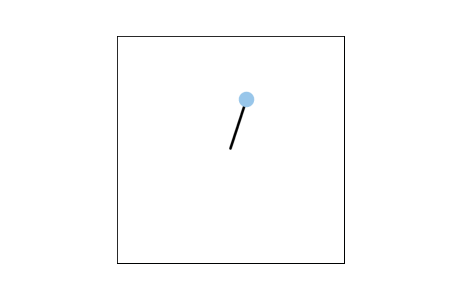

In [11]:
from sb3_contrib import SafetyCBF

def actuated_dynamics_fn(env):
    return np.array([env.dt ** 2, env.dt])

def punishment_fn(env, safe_region, action_rl, compensation):
        return -abs(compensation)

    
# Initialise environment
env = gym.make('MathPendulum-v0', init="random", safe_region=safe_region)

env = SafetyCBF(
            env=env,
            safe_region=safe_region,
            dynamics_fn=dynamics_fn,
            actuated_dynamics_fn=actuated_dynamics_fn,
            # unactuated_dynamics_fn=unactuated_dynamics_fn
            punishment_fn=punishment_fn,
            transform_action_space_fn=transform_action_space_fn,
            alter_action_space=alter_action_space,
            gamma=0.5)

# Wrap with Monitor (suppress warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

# Rollout
#rollout(env, render=True, rgb_array=False, sleep=0.1)

# Rollout and save as gif
frames = rollout(env, render=True, rgb_array=True, sleep=0)
anim = animate(frames, dpi=75)
anim.save('gifs/cbf.gif', writer='imagemagick', fps=20)
with open('gifs/cbf.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

This notebook should give an intuition to the safety wrappers. For more specifics, see the top-level README.md